In [116]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tigercontrol
from tigercontrol.controllers import Controller
from jax import grad,jit
import jax
from tigercontrol.utils.random import set_key
import jax.random as random
from tigercontrol.utils import generate_key

In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
def get_trajectory(environment, controller, T = 500, key = 0):
    set_key(key)

    (environment_id, environment_params) = environment
    (controller_id, controller_params) = controller
    
    environment = tigercontrol.environment(environment_id)
    x = environment.reset(**environment_params)
    
    controller_params['A'], controller_params['B'] = environment.A, environment.B
    controller_params['x'] = x
    
    controller = tigercontrol.controllers(controller_id)
    controller.initialize(**controller_params)
    
    trajectory = []
    norms = []
    avg_norms = []
    cur_avg = 0
    
    if(controller.is_online):
        for i in range(T):
            u = controller.plan(x)
            x = environment.step(u)
            trajectory.append(x) # get trajectory
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u)) / (i + 1)
            avg_norms.append(cur_avg)
    else:
        u = controller.plan()
        for i in range(T):
            x = environment.step(u[i])
            trajectory.append(x)
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u[i])) / (i + 1)
            avg_norms.append(cur_avg)
            
    return np.array(trajectory), np.array(norms), np.array(avg_norms)

In [119]:
def get_avg_performance(environment, controller, T = 500, n_runs = 20):
    _, _, avg_norms = get_trajectory(environment, controller, T = T, key = 0)
    avg_norms *= (1 / n_runs)
    for i in range(1, n_runs):
        _, _, add = get_trajectory(environment, controller, T = T, key = i)
        avg_norms = avg_norms + (1 / n_runs) * add
    return avg_norms

# LDS Experiments

For the LDS system, the matrices A, B are generated randomly. The cost function used is c(x, u) = ||x||2 + ||u||2 . The baseline is designed with the pre-fixed matrix K set to 0. In all figures, we plot the averaged results for a fixed random system determined by A, B, for each setting, over 20 experiment runs.

In [120]:
n_runs = 1

## Sanity Check

We experiment with a simple LDS in which the noises w_t are independently normally distributed with zero mean, and $0.1^2$ variance. We set the memory length to H = 20 for d = 1, and H = 5 for the larger dimensions. We demonstrate results for systems with different dimensions: (a) d = 1; (b) d = 10; (c) d = 100.

In [121]:
noise_magnitude = 0.1
noise_distribution = 'normal'

(a) d = 1, H = 20

In [122]:
T = 200

In [123]:
n = 1 # dimension of  the state x 
m = 1 # control dimension

environment_id = "LDS-v0"
environment_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

In [124]:
H, HH = 20, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}

In [125]:
GPC_avg_results = get_avg_performance((environment_id, environment_params), ('GPC', GPC_params), \
                                                              T = T, n_runs = n_runs)

In [126]:
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}

In [127]:
LQR_avg_results = get_avg_performance((environment_id, environment_params), ('LQR', LQR_params), T = T, n_runs = n_runs)

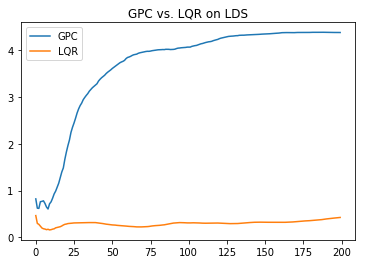

In [128]:
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

(b) d = 10, H = 5

In [129]:
T = 100

In [130]:
n = 10 # dimension of  the state x 
m = 10 # control dimension
environment_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

In [131]:
H, HH = 5, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}
GPC_avg_results = get_avg_performance((environment_id, environment_params), ('GPC', GPC_params), \
                                                              T = T, n_runs = n_runs)

In [132]:
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}
LQR_avg_results = get_avg_performance((environment_id, environment_params), ('LQR', LQR_params), T = T, n_runs = n_runs)

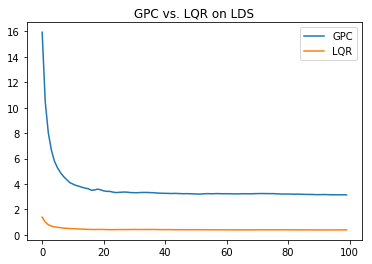

In [133]:
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

(c) d = 100, H = 5

In [134]:
T = 100

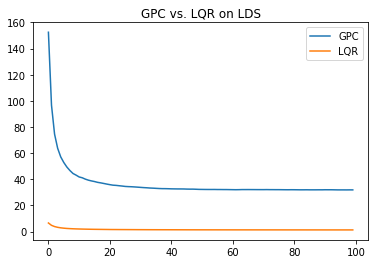

In [135]:
## PROBLEM ##
n = 100 # dimension of  the state x 
m = 100 # control dimension
environment_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

## GPC ###
H, HH = 5, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}
GPC_avg_results = get_avg_performance((environment_id, environment_params), ('GPC', GPC_params), \
                                                              T = T, n_runs = n_runs)

## LQR ##
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}
LQR_avg_results = get_avg_performance((environment_id, environment_params), ('LQR', LQR_params), T = T, n_runs = n_runs)

## RESULTS ##
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

## Correlated noise experiment

### Gaussian Random Walk

In the first setting, the noise terms are $w_{t+1} ∼ N(w_t,0.3^2)$, and are then clipped to the range [−1, 1].

In [136]:
T = 500

In [137]:
noise_magnitude = 0.3

In [138]:
def get_next_w(n, x, u, w, t):
    next_w = w + noise_magnitude * random.normal(generate_key())
    next_w = min(1, next_w)
    next_w = max(-1, next_w)
    return next_w

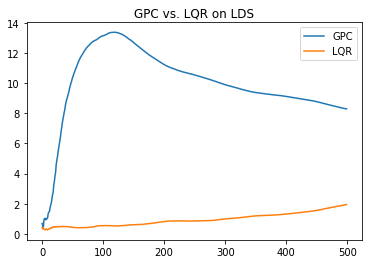

In [139]:
## PROBLEM ##
n = 1 # dimension of  the state x 
m = 1 # control dimension
environment_params = {'n': n, 'm' : m, 'noise_distribution' : get_next_w}

## GPC ###
H, HH = 20, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}
GPC_avg_results = get_avg_performance((environment_id, environment_params), ('GPC', GPC_params), \
                                                              T = T, n_runs = n_runs)

## LQR ##
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}
LQR_avg_results = get_avg_performance((environment_id, environment_params), ('LQR', LQR_params), T = T, n_runs = n_runs)

## RESULTS ##
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

### Sine Noise

The sine function is applied to the time index, i.e., $w_t = sin(t)$.

In [140]:
T = 200

In [141]:
def get_next_w(n, x, u, w, t):
    return np.sin(t)

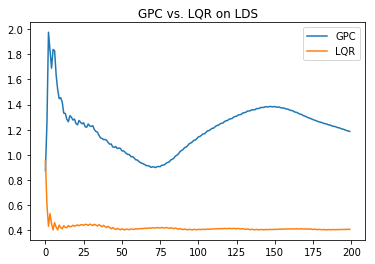

In [142]:
## PROBLEM ##
n = 1 # dimension of  the state x 
m = 1 # control dimension
environment_params = {'n': n, 'm' : m, 'noise_distribution' : get_next_w}

## GPC ###
H, HH = 5, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}
GPC_avg_results = get_avg_performance((environment_id, environment_params), ('GPC', GPC_params), \
                                                              T = T, n_runs = n_runs)

## LQR ##
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}
LQR_avg_results = get_avg_performance((environment_id, environment_params), ('LQR', LQR_params), T = T, n_runs = n_runs)

## RESULTS ##
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();